### Pruning point sources from the CLASH catalog

In [1]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt

from os.path import expanduser
from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()
from wlenet.cluster.cluster_lensing import ClusterLensing
from wlenet.cluster.cluster_survey import ClusterSurvey
from wlenet.dataset.figures import show_stamps
from wlenet.misc.figures import abline

In [2]:
save_extra_cut = False
save_figures = True

In [3]:
clash_zeropoint_path = expanduser(config['calibration_path'] + '/clash_zeropoint.npy')
clash_zeropoint = np.load(clash_zeropoint_path)

In [4]:
%%capture
survey = ClusterSurvey()
survey.process_survey(parallel=True)

In [5]:
mu_max = survey.cut['mu_max']
mag_auto = survey.cut['mag_auto'] + clash_zeropoint
flux_radius = survey.cut['flux_radius']
stamps = survey.cut['stamps']

In [6]:
flux_radius_min = 0
flux_radius_max = 1.5
mag_auto_min = -7 + clash_zeropoint
mag_auto_max = -0.25 + clash_zeropoint
mag_delta_left = 0.4
mag_delta_right = 0.9

In [7]:
pt_srcs_flux_radius = (flux_radius > flux_radius_min) * (flux_radius < flux_radius_max) * (mag_auto > mag_auto_min) * (mag_auto < mag_auto_max)

(0, 20)

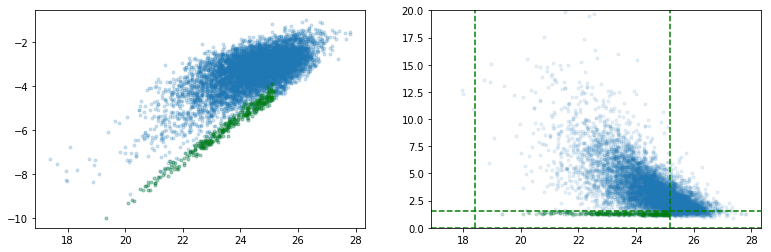

In [8]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(mag_auto, mu_max, '.', alpha=0.2)
plt.plot(mag_auto[pt_srcs_flux_radius], mu_max[pt_srcs_flux_radius], 'g.', alpha=0.2)

plt.subplot(1,2,2)
plt.plot(mag_auto, flux_radius, '.', alpha=0.1)
plt.plot(mag_auto[pt_srcs_flux_radius], flux_radius[pt_srcs_flux_radius], 'g.', alpha=0.1)
plt.axhline(y=flux_radius_min, linestyle='--', color='green')
plt.axhline(y=flux_radius_max, linestyle='--', color='green')
plt.axvline(x=mag_auto_min, linestyle='--', color='green')
plt.axvline(x=mag_auto_max, linestyle='--', color='green')
plt.ylim([0, 20])

In [9]:
fit = np.polyfit(mag_auto[pt_srcs_flux_radius], mu_max[pt_srcs_flux_radius], 1)
mu_max_max = np.max(mu_max[pt_srcs_flux_radius])

(0, 20)

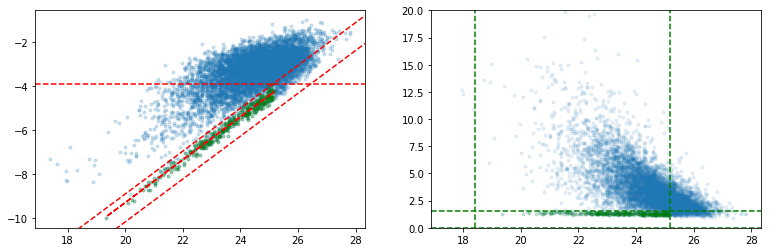

In [10]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.plot(mag_auto, mu_max, '.', alpha=0.2)
plt.plot(mag_auto[pt_srcs_flux_radius], mu_max[pt_srcs_flux_radius], 'g.', alpha=0.2)

plt.plot(mag_auto[pt_srcs_flux_radius], fit[0]*mag_auto[pt_srcs_flux_radius] + fit[1], 'r--')
abline(fit[0], fit[1] + mag_delta_left*fit[0], 'r--')
abline(fit[0], fit[1] - mag_delta_right*fit[0], 'r--')
plt.axhline(y=mu_max_max, linestyle='--', color='red')

plt.subplot(1,2,2)
plt.plot(mag_auto, flux_radius, '.', alpha=0.1)
plt.plot(mag_auto[pt_srcs_flux_radius], flux_radius[pt_srcs_flux_radius], 'g.', alpha=0.1)
plt.axhline(y=flux_radius_min, linestyle='--', color='green')
plt.axhline(y=flux_radius_max, linestyle='--', color='green')
plt.axvline(x=mag_auto_min, linestyle='--', color='green')
plt.axvline(x=mag_auto_max, linestyle='--', color='green')
plt.ylim([0, 20])

In [11]:
mag_lim_max = -fit[1]/fit[0] + mu_max/fit[0] + mag_delta_right
mag_lim_min = -fit[1]/fit[0] + mu_max/fit[0] - mag_delta_left
pt_srcs_mu_max = (mu_max < mu_max_max) * (mag_auto < mag_lim_max) * (mag_auto > mag_lim_min)

pt_srcs = pt_srcs_mu_max + pt_srcs_flux_radius
bad_srcs = mag_auto > mag_lim_max

(0, 20)

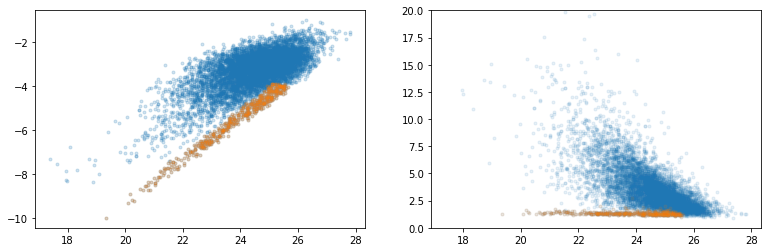

In [12]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(mag_auto, mu_max, '.', alpha=0.2)
plt.plot(mag_auto[pt_srcs], mu_max[pt_srcs], '.', alpha=0.2)
plt.plot(mag_auto[bad_srcs], mu_max[bad_srcs], '.', alpha=0.2)

plt.subplot(1,2,2)
plt.plot(mag_auto, flux_radius, '.', alpha=0.1)
plt.plot(mag_auto[pt_srcs], flux_radius[pt_srcs], '.', alpha=0.1)
plt.plot(mag_auto[bad_srcs], flux_radius[bad_srcs], '.', alpha=0.1)
plt.ylim([0, 20])

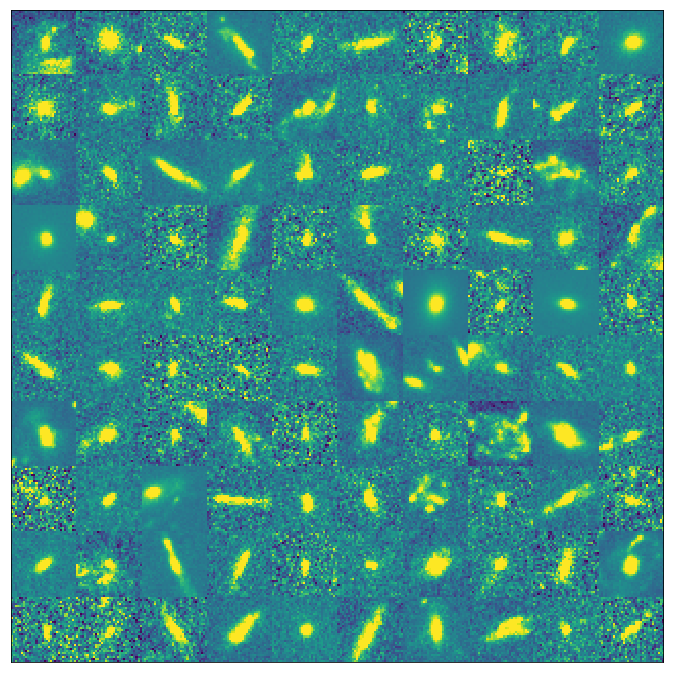

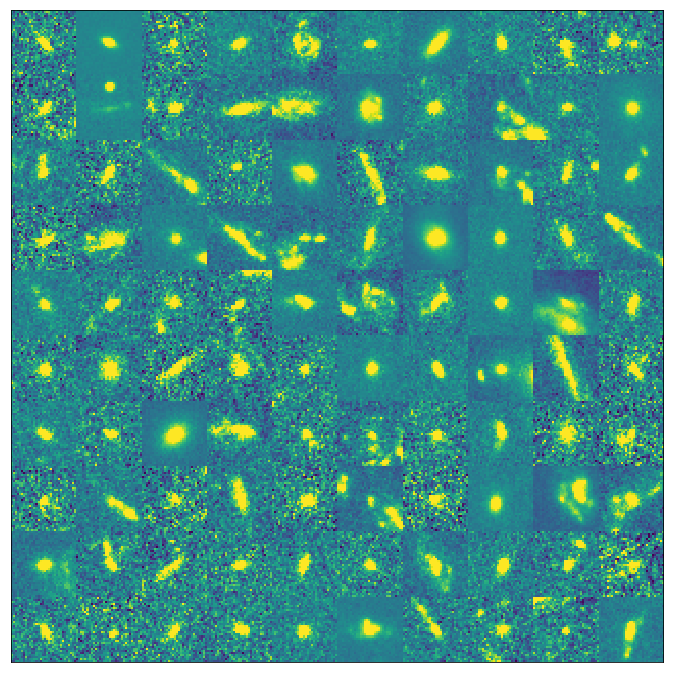

In [13]:
valid_indices = np.where(~(pt_srcs + bad_srcs))[0]
np.random.seed(1234)
permed_valid_indices = np.random.permutation(valid_indices)

from wlenet.dataset.normalization import norm_max, norm_mean_std, norm_sum

show_stamps(stamps[permed_valid_indices], num_pages=2, norm_func=norm_mean_std)

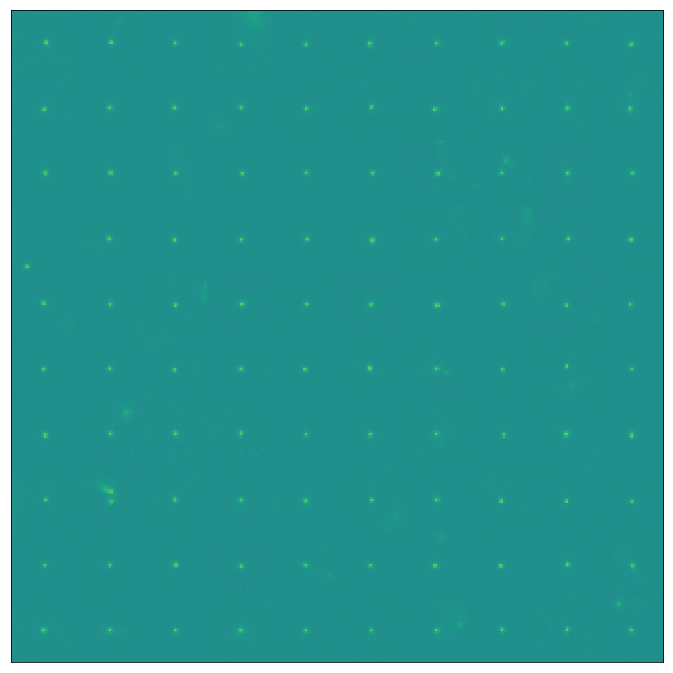

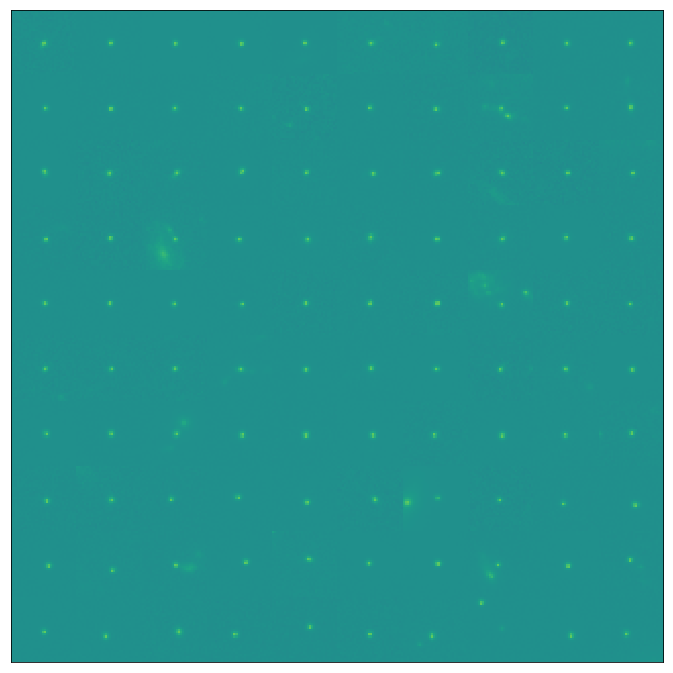

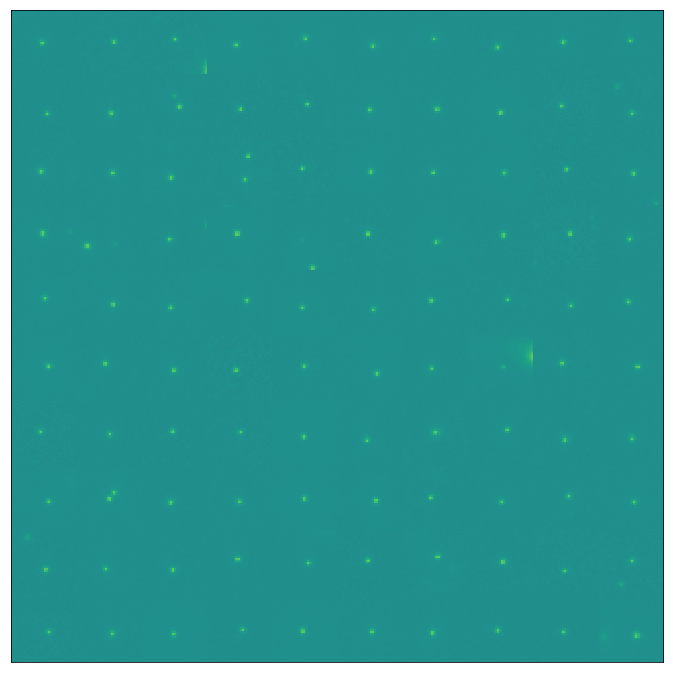

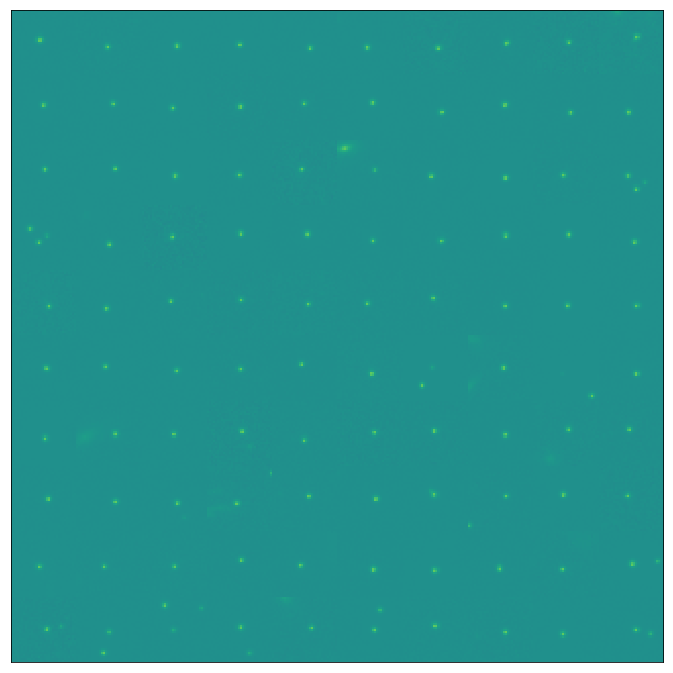

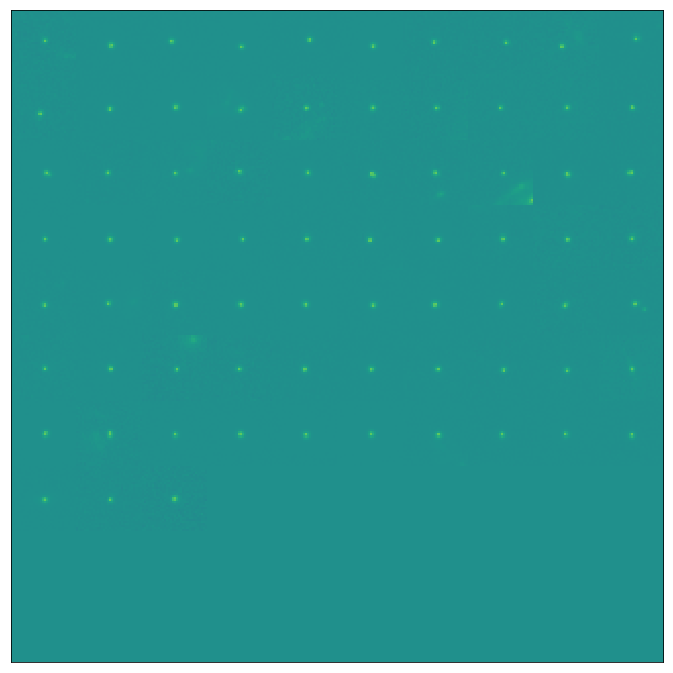

In [14]:
show_stamps(stamps[pt_srcs, ...], norm_func=norm_max)

In [15]:
show_stamps(stamps[bad_srcs, ...], norm_func=norm_mean_std)

In [16]:
if save_extra_cut:
    extra_cut_path = expanduser(config['calibration_path'] + '/clash_extra_cut.npy')
    cut_mask = ~(pt_srcs + bad_srcs)
    cut_inds = np.where(cut_mask)[0]
    extra_cut = {'cut_inds': cut_inds,
                 'cut_mask': cut_mask,
                 'source_id': survey.cut['source_id'], 
                 'cluster_id': survey.cut['cluster_id']}
    np.save(extra_cut_path, extra_cut)

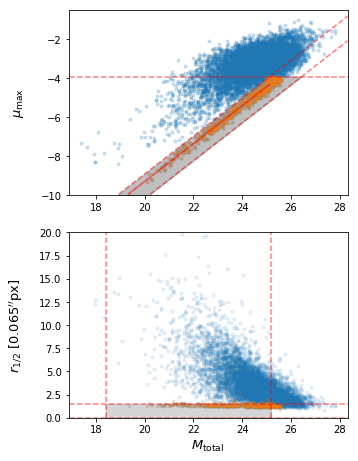

In [17]:
plt.figure(figsize=(5, 7.5))

plt.subplot(2,1,1)

plt.plot(mag_auto, mu_max, '.', alpha=0.2)
plt.plot(mag_auto[pt_srcs], mu_max[pt_srcs], '.', alpha=0.2)
plt.plot(mag_auto[bad_srcs], mu_max[bad_srcs], '.', alpha=0.2)

fby = np.linspace(-10, mu_max_max, 100)
fbx1 = (fby - fit[1] - mag_delta_left*fit[0]) / fit[0]
fbx2 = (fby - fit[1] + mag_delta_right*fit[0]) / fit[0]
plt.fill_betweenx(fby, fbx1, fbx2, color='grey', alpha='0.5')

plt.plot(mag_auto[pt_srcs_flux_radius], fit[0]*mag_auto[pt_srcs_flux_radius] + fit[1], 'r--', alpha=0.5)
abline(fit[0], fit[1] + mag_delta_left*fit[0], 'r--', alpha=0.5)
abline(fit[0], fit[1] - mag_delta_right*fit[0], 'r--', alpha=0.5)
plt.axhline(y=mu_max_max, linestyle='--', color='red', alpha=0.5)

#plt.xlabel(r'$M_{\mathrm{total}}$', fontsize=13)
plt.ylabel(r'$\mu_{\mathrm{max}}$', fontsize=13, labelpad=15)
plt.ylim([-10, -0.5])

plt.subplot(2,1,2)

plt.fill_between([mag_auto_min, mag_auto_max], 
                 [flux_radius_min, flux_radius_min], 
                 [flux_radius_max, flux_radius_max], color='grey', alpha='0.33')

plt.plot(mag_auto, flux_radius, '.', alpha=0.1)
plt.plot(mag_auto[pt_srcs], flux_radius[pt_srcs], '.', alpha=0.1)
plt.plot(mag_auto[bad_srcs], flux_radius[bad_srcs], '.', alpha=0.1)

plt.axhline(y=flux_radius_min, linestyle='--', color='red', alpha=0.5)
plt.axhline(y=flux_radius_max, linestyle='--', color='red', alpha=0.5)
plt.axvline(x=mag_auto_min, linestyle='--', color='red', alpha=0.5)
plt.axvline(x=mag_auto_max, linestyle='--', color='red', alpha=0.5)

plt.xlabel(r'$M_{\mathrm{total}}$', fontsize=13)
plt.ylabel(r"$r_{1/2}$ [$0.065''$px]", fontsize=13, labelpad=15)
plt.ylim([0, 20])

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/point_sources_clash.pdf')
    plt.savefig(fig_path, bbox_inches='tight')

Point sources (orange) and false detections (green) identified in the CLASH background source catalog.

In [18]:
fwhm_image_pt_srcs = survey.cut['fwhm_image'][pt_srcs]

cent = [13, 19]
stamps_pt_srcs = survey.cut['stamps'][pt_srcs]
concent_pt_srcs = np.sum(stamps_pt_srcs[:, cent[0]:cent[1], cent[0]:cent[1]], axis=(1,2))
concent_pt_srcs /= np.sum(stamps_pt_srcs, axis=(1,2))


inliers = (fwhm_image_pt_srcs < 2.5) * concent_pt_srcs > 0.9
inliers_orig = inliers.copy()
inliers[np.where(inliers_orig)[0][18]] = False
inliers[np.where(inliers_orig)[0][71]] = False
stamps_inliers = stamps_pt_srcs[inliers, :, :]

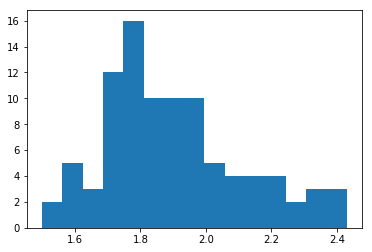

In [19]:
plt.hist(fwhm_image_pt_srcs[inliers], bins=15);

In [20]:
np.array([np.median(fwhm_image_pt_srcs[inliers]), np.mean(fwhm_image_pt_srcs[inliers])]) * 0.065

array([0.1209    , 0.12331129])

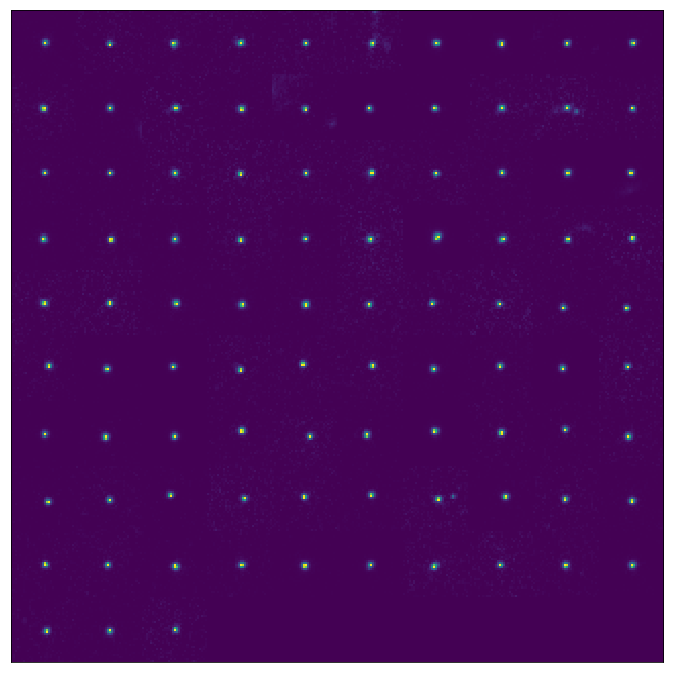

In [21]:
show_stamps(norm_max(stamps_inliers), norm_func=None, clim=[0,1])

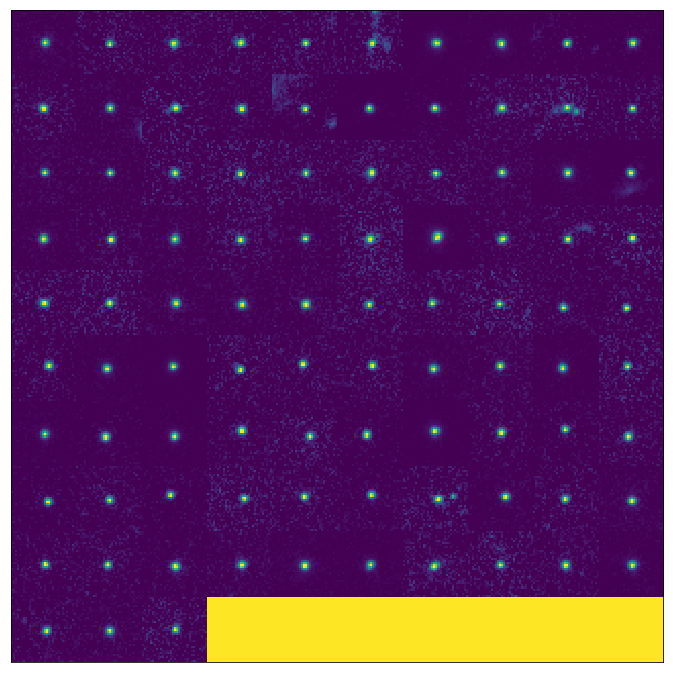

In [22]:
show_stamps(np.log10(0.1+norm_max(stamps_inliers)), norm_func=None, clim=[-1,0])

In [23]:
survey.remove_tmp_files()